# Deep Learning, CNN Trainging 2 ModelS

# Model 1(Base CNN)

## Importing all the required Libraries

### Ignore warnings

In [3]:
import warnings
warnings.filterwarnings("ignore")

### Torch Library

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.utils import make_grid
import os
from torchvision.datasets import ImageFolder
from PIL import Image
from torch.utils.data import Dataset

### pandas library


In [5]:
import pandas as pd

### Numpy Library

In [6]:
import numpy as np

### Matplotlib Library

In [7]:
import matplotlib.pyplot as plt

### SKlearn Libraries

In [8]:
import time
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Ray 

In [9]:
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune import CLIReporter


# All Default Libraries

In [10]:
from collections import defaultdict
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image

# Captum

In [11]:
! pip install captum
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization
from captum.attr import Occlusion
from captum.attr import GradientShap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.1 MB/s eta 0:00:0000:010:01


# Defining directory for Train and Validation

In [12]:
data_dir_train = '/kaggle/input/deep-learning-for-msc-2022-23/train'
csv_file = '/kaggle/input/deep-learning-for-msc-2022-23/train.csv'

# Defining Directory for Test

In [13]:
csv_file_CNN='/kaggle/input/deep-learning-for-msc-2022-23/example.csv'
data_dir_test= '/kaggle/input/deep-learning-for-msc-2022-23/test'

# Transformation of image to avoid overfitting

### Transformation function for Train Data set, Rotating, flipping, normalizing and converting to tensor

In [14]:
train_transform_predataloader=transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(7),transforms.ToTensor(),transforms.Normalize([0.475, 0.476, 0.405],[0.227, 0.225, 0.226])])


### Transformation function for the Validation/Test Data set normalizing and converting to tensor

In [15]:
test_transform_predataloader=transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.475, 0.476, 0.405],[0.227, 0.225, 0.226])])


# Custom data loader For Train and Test (For Test I have kept 19%  images from each class and the remaining image for training)

### Defining a CustomDataSet Function

In [16]:
class kan_CustomDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.transform=transform
        self.root_dir=root_dir
        self.annotations=pd.read_csv(csv_file)
    def __getitem__(self, index):
        path_i=self.annotations.iloc[index, 0]
        image=Image.open(self.root_dir + '/' + path_i)
        image=image.convert('RGB')
        if self.transform is not None:
            image=self.transform(image)
        label=self.annotations.iloc[index, 1]
        return image,label
    def __len__(self):
        x=len(self.annotations)
        return x

### Using the Custom Dataset Function and storing it in a variable

In [17]:
Whole_dataset=kan_CustomDataset(csv_file=csv_file,root_dir=data_dir_train,transform=train_transform_predataloader)

## Using SKLearn Train, Test Split function to split the data on the Training and validation set

In [18]:
train,val=train_test_split(np.arange(len(Whole_dataset)),random_state=32,test_size=0.19)
val=Subset(Whole_dataset,val)
Train=Subset(Whole_dataset,train)

## Printing all the Classes which are there in the datset

In [19]:
classes = Whole_dataset.annotations.Label.unique()
print(f"All the calsses are {classes}")

All the calsses are [0 1 2 3]


### Data Loader for Train

### Using manual seed just for reproducability

### Used 2 workers, and batch size 16

In [20]:
torch.manual_seed(49)
train_loader=DataLoader(Train,num_workers=2,batch_size=16,shuffle=True)

### Checking number of item in the Training Set

In [21]:
Training_image_size=0
for images, labels in train_loader:
    Training_image_size=Training_image_size+len(labels)
print(f"Total Images in Training Set: {Training_image_size}")

Total Images in Training Set: 6123


### Check the Tensor size as 16

In [22]:
warnings.filterwarnings("ignore")
for images, labels in train_loader:
    print(f"Structure for the Train Loader: {labels}")
    break

Structure for the Train Loader: tensor([1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 0, 3])


### Check the Classes and their Count on the Training Set

In [23]:
print("Training Set")
LC=defaultdict(int)
for b,(item, L) in enumerate(train_loader):
    for l in L:
        LC[l.item()]+=1
for l, c in LC.items():
    print(f"Label(Classification Number) {l} with Instances {c}")

Training Set
Label(Classification Number) 2 with Instances 563
Label(Classification Number) 1 with Instances 2801
Label(Classification Number) 3 with Instances 2173
Label(Classification Number) 0 with Instances 586


# Data Loader for Validation

In [24]:
torch.manual_seed(45)
test_loader=DataLoader(val,batch_size=16,shuffle=False)

### Check the Classes and their Count on the Validation Set

In [25]:
print("Validation Set")
LC=defaultdict(int)
for b,(item,L) in enumerate(test_loader):
    for l in L:
        LC[l.item()]+=1
for l,c in LC.items():
    print(f"Label(Classification Number) {l} with Instances {c}")

Validation Set
Label(Classification Number) 1 with Instances 661
Label(Classification Number) 2 with Instances 116
Label(Classification Number) 3 with Instances 517
Label(Classification Number) 0 with Instances 143


### Checking number of item in the Validation Set

In [26]:
Validation_image_size=0
for images, labels in test_loader:
    Validation_image_size=Validation_image_size+len(labels)
print(f"Validation Image Size: {Validation_image_size}")

Validation Image Size: 1437


### Check the Tensor size as 16

In [27]:
for images,labels in test_loader:
    print(f"Structure for the Validation Loader: {labels}")
    break

Structure for the Validation Loader: tensor([1, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 3, 0])


# Visualize few images

In [28]:
for pic,number in train_loader: 
    break
# just to see the first batch

## Showing 16 images from the first train data loader

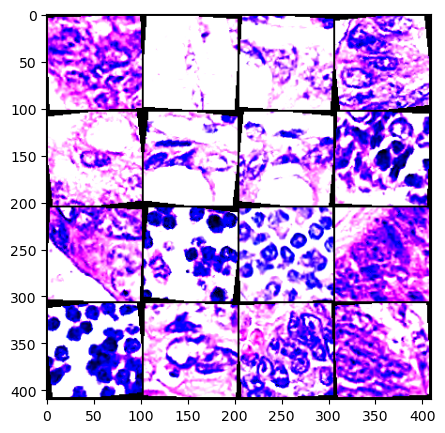

In [29]:
warnings.filterwarnings("ignore")
few_image_train=make_grid(pic, nrow=4) 
plt.figure(figsize=(15,5))
plt.imshow(np.transpose(few_image_train.numpy(),(1, 2, 0)));

## Showing 16 images from the first Validation data loader

In [30]:
for pic,number in test_loader: 
    break

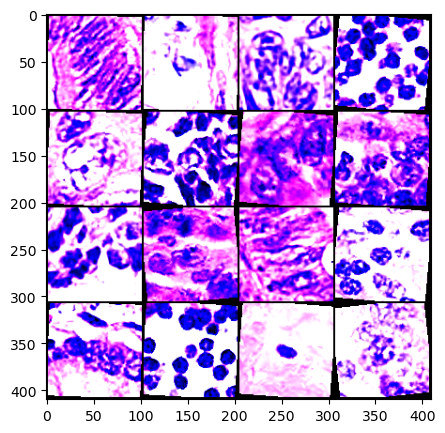

In [31]:
warnings.filterwarnings("ignore")
few_image_Val=make_grid(pic,nrow=4) 
plt.figure(figsize=(15,5))
plt.imshow(np.transpose(few_image_Val.numpy(),(1, 2, 0)));

# Train and Validation Sample Size

In [32]:
print(f"Number of images in Train dataset: {len(train_loader.dataset)}")

print(f"Number of images in Validation dataset: {len(test_loader.dataset)}")

Number of images in Train dataset: 6123
Number of images in Validation dataset: 1437


# Creating a Base CNN Model with 4 layers

In [33]:
class CNN_Base_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.First=nn.Conv2d(3,6,3,1)
        self.Lay1=nn.Linear(49*49*6,5000)
        self.Lay2=nn.Linear(5000,2000)
        #self.Lay3=nn.Linear(2000,1000)
        #self.Lay4=nn.Linear(1000,200)
        #self.Lay5=nn.Linear(200,84)
        #self.Lay6=nn.Linear(84,42)
        self.Lay7=nn.Linear(2000, 4)
    def forward(self, X):
        X=F.relu(self.First(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,49*49*6)
        X=F.relu(self.Lay1(X))
        X=F.relu(self.Lay2(X))
        #X=F.relu(self.Lay3(X))
        #X=F.relu(self.Lay4(X))
        #X=F.relu(self.Lay5(X))
        #X=F.relu(self.Lay6(X))
        X=self.Lay7(X)
        return F.log_softmax(X, dim=1)

# Defining the number of Epoch for the Hyper parameter Tuning

In [34]:
epochs_CNN_HT=6

# Check GPU Availablity

In [35]:
rand=CNN_Base_Model()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
rand=rand.to(device)
print(device)

cuda


# Model for Hyper parameter Tuning

In [36]:
def train_val_CNN(config):
    model_CNN_HT=CNN_Base_Model()
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_CNN_HT=model_CNN_HT.to(device)
    Adam_Optimizer_CNN_HT=torch.optim.Adam(model_CNN_HT.parameters(),lr=config['lr'])
    L_Func_CNN_HT=nn.CrossEntropyLoss()
    for i in range(epochs_CNN_HT):
        for n,(train,label) in enumerate(train_loader):
            n=n+1
            train,label=train.to(device),label.to(device)
            Adam_Optimizer_CNN_HT.zero_grad()
            label_pred=model_CNN_HT(train) 
            loss_CNN_HT=L_Func_CNN_HT(label_pred, label)
            loss_CNN_HT.backward()
            Adam_Optimizer_CNN_HT.step()
        tune.report(loss_CNN_HT=loss_CNN_HT.item())

# ASHAScheduler

#### To get the minimum value

In [37]:
ashascheduler=ASHAScheduler(metric='loss_CNN_HT',mode='min')

# Reporter

In [38]:
rep=CLIReporter(metric_columns=['loss_CNN_HT','iter'])

# Config

#### LR range in between 1e-5 to 1e-3

In [39]:
HT_LR={"lr":tune.loguniform(1e-5, 1e-3)}

# Running thr Hyper parameter test

#### With 2GPU and 15 Samples

In [40]:
warnings.filterwarnings("ignore")
kan=tune.run(train_val_CNN,config=HT_LR,scheduler=ashascheduler,resources_per_trial={"gpu": 2, "cpu": 2},progress_reporter=rep,num_samples=15)


2023-03-25 21:48:17,892	INFO worker.py:1535 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
E0325 21:48:21.724676228      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:48:22 (running for 00:00:00.55)
Memory usage on this node: 3.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------------+----------+----------------+-------------+
| Trial name                | status   | loc            |          lr |
|---------------------------+----------+----------------+-------------|
| train_val_CNN_c30a4_00000 | RUNNING  | 172.19.2.2:408 | 0.000382431 |
| train_val_CNN_c30a4_00001 | PENDING  |                | 0.00026073  |
| train_val_CNN_c30a4_00002 | PENDING  |                | 6.34802e-05 |
| train_val_CNN_c30a4_00003 | PENDING  |                | 1.01524e-05 |
| train_val_CNN_c30a4_00004 | P

(train_val_CNN pid=408) E0325 21:48:30.818281965     450 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_val_CNN pid=408) E0325 21:48:30.833884016     450 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:48:32 (running for 00:00:10.86)
Memory usage on this node: 4.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------------+----------+----------------+-------------+
| Trial name                | status   | loc            |          lr |
|---------------------------+----------+----------------+-------------|
| train_val_CNN_c30a4_00000 | RUNNING  | 172.19.2.2:408 | 0.000382431 |
| train_val_CNN_c30a4_00001 | PENDING  |                | 0.00026073  |
| train_val_CNN_c30a4_00002 | PENDING  |                | 6.34802e-05 |
| train_val_CNN_c30a4_00003 | PENDING  |                | 1.01524e-05 |
| train_val_CNN_c30a4_00004 | P

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss_CNN_HT,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_val_CNN_c30a4_00000,2023-03-25_21-50-12,True,,4e352fb21e94497593fb0a47296585c8,0_lr=0.0004,515ce20ed684,6,0.611726,172.19.2.2,408,104.906,15.3565,104.906,1679781012,0,,6,c30a4_00000,0.00530553
train_val_CNN_c30a4_00001,2023-03-25_21-50-38,True,,cf2ab51d1c1345fc9b232f3ea0c2e7d1,,515ce20ed684,1,0.850807,172.19.2.2,666,20.9048,20.9048,20.9048,1679781038,0,,1,c30a4_00001,0.0059495
train_val_CNN_c30a4_00002,2023-03-25_21-52-23,True,,dcc3d5afc2b142619377b98dd2a38e26,2_lr=0.0001,515ce20ed684,6,0.50186,172.19.2.2,751,99.5719,15.2945,99.5719,1679781143,0,,6,c30a4_00002,0.00574541
train_val_CNN_c30a4_00003,2023-03-25_21-52-50,True,,fcc6bd93b8ab4b358deeaeda5f3c0fa9,,515ce20ed684,1,0.407714,172.19.2.2,1009,21.2064,21.2064,21.2064,1679781170,0,,1,c30a4_00003,0.00538373
train_val_CNN_c30a4_00004,2023-03-25_21-53-16,True,,e8ad3778e95e47bfbb2586baa1b8f584,,515ce20ed684,1,0.429655,172.19.2.2,1094,21.0683,21.0683,21.0683,1679781196,0,,1,c30a4_00004,0.00626087
train_val_CNN_c30a4_00005,2023-03-25_21-53-43,True,,76b319cfa0984700a7e810c86306a83d,,515ce20ed684,1,0.54551,172.19.2.2,1174,21.2713,21.2713,21.2713,1679781223,0,,1,c30a4_00005,0.00628304
train_val_CNN_c30a4_00006,2023-03-25_21-54-10,True,,78d2e8b3d26443029b796f651491227b,,515ce20ed684,1,0.427677,172.19.2.2,1251,21.1252,21.1252,21.1252,1679781250,0,,1,c30a4_00006,0.0056138
train_val_CNN_c30a4_00007,2023-03-25_21-54-36,True,,754a9870b88e406cbad75690e1f3bd5b,,515ce20ed684,1,1.08164,172.19.2.2,1331,21.1157,21.1157,21.1157,1679781276,0,,1,c30a4_00007,0.00848866
train_val_CNN_c30a4_00008,2023-03-25_21-55-03,True,,c5bab12d79c3422caa97a5babfb069fc,,515ce20ed684,1,0.399496,172.19.2.2,1408,20.9683,20.9683,20.9683,1679781303,0,,1,c30a4_00008,0.00814414
train_val_CNN_c30a4_00009,2023-03-25_21-55-30,True,,d9336e7c393e459db88f0797bd754931,,515ce20ed684,1,0.872254,172.19.2.2,1493,21.3997,21.3997,21.3997,1679781330,0,,1,c30a4_00009,0.00498652


== Status ==
Current time: 2023-03-25 21:48:58 (running for 00:00:36.06)
Memory usage on this node: 5.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -0.12241197377443314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------------+----------+----------------+-------------+---------------+
| Trial name                | status   | loc            |          lr |   loss_CNN_HT |
|---------------------------+----------+----------------+-------------+---------------|
| train_val_CNN_c30a4_00000 | RUNNING  | 172.19.2.2:408 | 0.000382431 |      0.122412 |
| train_val_CNN_c30a4_00001 | PENDING  |                | 0.00026073  |               |
| train_val_CNN_c30a4_00002 | PENDING  |                | 6.34802e-05 |        

(train_val_CNN pid=408) E0325 21:49:57.463337349     450 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:50:02 (running for 00:01:40.40)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.5474826693534851 | Iter 1.000: -0.12241197377443314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+---------------------------+----------+----------------+-------------+---------------+
| Trial name                | status   | loc            |          lr |   loss_CNN_HT |
|---------------------------+----------+----------------+-------------+---------------|
| train_val_CNN_c30a4_00000 | RUNNING  | 172.19.2.2:408 | 0.000382431 |      0.337435 |
| train_val_CNN_c30a4_00001 | PENDING  |                | 0.00026073  |               |
| train_val_CNN_c30a4_00002 | PENDING  |                | 6.3480

(train_val_CNN pid=666) E0325 21:50:20.736145167     708 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:50:23 (running for 00:02:01.07)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.5474826693534851 | Iter 1.000: -0.12241197377443314
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+---------------------------+------------+----------------+-------------+---------------+
| Trial name                | status     | loc            |          lr |   loss_CNN_HT |
|---------------------------+------------+----------------+-------------+---------------|
| train_val_CNN_c30a4_00001 | RUNNING    | 172.19.2.2:666 | 0.00026073  |               |
| train_val_CNN_c30a4_00002 | PENDING    |                | 6.34802e-05 |               |
| train_val_CNN_c30a4_00003 | PENDING   

(train_val_CNN pid=751) E0325 21:50:46.534142363     785 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:50:49 (running for 00:02:27.06)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.5474826693534851 | Iter 1.000: -0.3045107927173376
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------------+------------+----------------+-------------+---------------+
| Trial name                | status     | loc            |          lr |   loss_CNN_HT |
|---------------------------+------------+----------------+-------------+---------------|
| train_val_CNN_c30a4_00002 | RUNNING    | 172.19.2.2:751 | 6.34802e-05 |               |
| train_val_CNN_c30a4_00003 | PENDING    |                | 1.01524e-05 |               |
| train_val_CNN_c30a4_00004 | PENDING    

(train_val_CNN pid=751) E0325 21:51:05.071974860     785 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:51:10 (running for 00:02:48.02)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.5474826693534851 | Iter 1.000: -0.19118832424283028
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+---------------------------+------------+----------------+-------------+---------------+
| Trial name                | status     | loc            |          lr |   loss_CNN_HT |
|---------------------------+------------+----------------+-------------+---------------|
| train_val_CNN_c30a4_00002 | RUNNING    | 172.19.2.2:751 | 6.34802e-05 |      0.259965 |
| train_val_CNN_c30a4_00003 | PENDING    |                | 1.01524e-05 |               |
| train_val_CNN_c30a4_00004 | PENDING   

(train_val_CNN pid=1009) E0325 21:52:31.775987699    1050 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:52:34 (running for 00:04:12.08)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.19118832424283028
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00003 | RUNNING    | 172.19.2.2:1009 | 1.01524e-05 |               |
| train_val_CNN_c30a4_00004 | PENDING    |                 | 0.000405047 |               |
| train_val_CNN_c30a4_00005 | PENDIN

(train_val_CNN pid=1094) E0325 21:52:58.645530702    1129 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:53:01 (running for 00:04:39.09)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.22557649947702885
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00004 | RUNNING    | 172.19.2.2:1094 | 0.000405047 |               |
| train_val_CNN_c30a4_00005 | PENDING    |                 | 5.2816e-05  |               |
| train_val_CNN_c30a4_00006 | PENDIN

(train_val_CNN pid=1174) E0325 21:53:25.201256458    1214 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_val_CNN pid=1174) E0325 21:53:25.219132049    1214 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:53:27 (running for 00:05:05.22)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.2599646747112274
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00005 | RUNNING    | 172.19.2.2:1174 | 5.2816e-05  |               |
| train_val_CNN_c30a4_00006 | PENDING    |                 | 0.000307274 |               |
| train_val_CNN_c30a4_00007 | PENDING 

(train_val_CNN pid=1251) E0325 21:53:51.904088982    1286 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:53:54 (running for 00:05:32.10)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.29690197110176086
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00006 | RUNNING    | 172.19.2.2:1251 | 0.000307274 |               |
| train_val_CNN_c30a4_00007 | PENDING    |                 | 0.000554458 |               |
| train_val_CNN_c30a4_00008 | PENDING

(train_val_CNN pid=1331) E0325 21:54:18.507739518    1366 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:54:20 (running for 00:05:58.44)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.3338392674922943
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00007 | RUNNING    | 172.19.2.2:1331 | 0.000554458 |               |
| train_val_CNN_c30a4_00008 | PENDING    |                 | 0.000696347 |               |
| train_val_CNN_c30a4_00009 | PENDING 

(train_val_CNN pid=1408) E0325 21:54:45.527783274    1449 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:54:47 (running for 00:06:25.37)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.37077656388282776
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00008 | RUNNING    | 172.19.2.2:1408 | 0.000696347 |               |
| train_val_CNN_c30a4_00009 | PENDING    |                 | 1.50512e-05 |               |
| train_val_CNN_c30a4_00010 | PENDING

(train_val_CNN pid=1578) E0325 21:55:38.971126388    1618 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:55:41 (running for 00:07:19.13)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.40155065804719925
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00010 | RUNNING    | 172.19.2.2:1578 | 3.715e-05   |               |
| train_val_CNN_c30a4_00011 | PENDING    |                 | 2.07541e-05 |               |
| train_val_CNN_c30a4_00012 | PENDIN

(train_val_CNN pid=1663) E0325 21:56:05.712258258    1697 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:56:08 (running for 00:07:46.12)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.40360505878925323
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00011 | RUNNING    | 172.19.2.2:1663 | 2.07541e-05 |               |
| train_val_CNN_c30a4_00012 | PENDING    |                 | 3.86091e-05 |               |
| train_val_CNN_c30a4_00013 | PENDIN

(train_val_CNN pid=1741) E0325 21:56:33.078102243    1781 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:56:35 (running for 00:08:13.19)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.4056594595313072
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00012 | RUNNING    | 172.19.2.2:1741 | 3.86091e-05 |               |
| train_val_CNN_c30a4_00013 | PENDING    |                 | 0.000632456 |               |
| train_val_CNN_c30a4_00014 | PENDIN

(train_val_CNN pid=1825) E0325 21:56:59.666363387    1859 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(train_val_CNN pid=1825) E0325 21:56:59.686330207    1859 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:57:02 (running for 00:08:40.13)
Memory usage on this node: 5.5/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.4077138602733612
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00013 | RUNNING    | 172.19.2.2:1825 | 0.000632456 |               |
| train_val_CNN_c30a4_00014 | PENDING    |                 | 0.00086275  |               |
| train_val_CNN_c30a4_00000 | TERMIN

(train_val_CNN pid=1896) E0325 21:57:44.496945279    1937 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:57:49 (running for 00:09:27.41)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.40360505878925323
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00014 | RUNNING    | 172.19.2.2:1896 | 0.00086275  |      0.325535 |
| train_val_CNN_c30a4_00000 | TERMINATED | 172.19.2.2:408  | 0.000382431 |      0.611726 |
| train_val_CNN_c30a4_00001 | TERMINATED | 172

(train_val_CNN pid=1896) E0325 21:58:15.952534879    1937 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:58:21 (running for 00:09:59.17)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.339899517595768 | Iter 1.000: -0.40360505878925323
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00014 | RUNNING    | 172.19.2.2:1896 | 0.00086275  |      0.532703 |
| train_val_CNN_c30a4_00000 | TERMINATED | 172.19.2.2:408  | 0.000382431 |      0.611726 |
| train_val_CNN_c30a4_00001 | TERMINATED | 172

(train_val_CNN pid=1896) E0325 21:58:47.472415870    1937 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 21:58:52 (running for 00:10:30.42)
Memory usage on this node: 5.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.29573436081409454 | Iter 1.000: -0.40360505878925323
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00014 | RUNNING    | 172.19.2.2:1896 | 0.00086275  |     0.0634883 |
| train_val_CNN_c30a4_00000 | TERMINATED | 172.19.2.2:408  | 0.000382431 |     0.611726  |
| train_val_CNN_c30a4_00001 | TERMINATED | 1

2023-03-25 21:59:03,529	INFO tune.py:763 -- Total run time: 641.84 seconds (641.34 seconds for the tuning loop).


== Status ==
Current time: 2023-03-25 21:59:03 (running for 00:10:41.36)
Memory usage on this node: 5.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.29573436081409454 | Iter 1.000: -0.40360505878925323
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/6.44 GiB heap, 0.0/3.22 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/train_val_CNN_2023-03-25_21-48-21
Number of trials: 15/15 (15 TERMINATED)
+---------------------------+------------+-----------------+-------------+---------------+
| Trial name                | status     | loc             |          lr |   loss_CNN_HT |
|---------------------------+------------+-----------------+-------------+---------------|
| train_val_CNN_c30a4_00000 | TERMINATED | 172.19.2.2:408  | 0.000382431 |      0.611726 |
| train_val_CNN_c30a4_00001 | TERMINATED | 172.19.2.2:666  | 0.00026073  |      0.850807 |
| train_val_CNN_c30a4_00002 | TERMINATED | 172.19.2.2:751  

## Checking the best Value for LR

In [41]:
LR_CNN=0
kan_best_CNN_Base=kan.get_best_config(metric='loss_CNN_HT',mode='min')
for key, value in kan_best_CNN_Base.items():
    LR_CNN=value
    print(f"Best Performing LR Score with 6 Epoch is : {LR_CNN}")

Best Performing LR Score with 6 Epoch is : 0.0008627495843915733


# Training the model With the best learning rate, that we get from the hypertuning

In [49]:
epochs_cnn_base = 6

# Defining Variable for Confusion Matrix and Accuracy

In [50]:
cm_CNN=[[]]
acc_CNN=0

# Defining few variables for plotting th graph

In [51]:
True_train_CNN = []
True_test_CNN = []
Loss_train_CNN = []
Loss_test_CNN = []

# Defining a start time variable to check the time for the execution

In [52]:
start_time_CNN=time.time()

# Checking CUDA Availablity

In [53]:
model_CNN=CNN_Base_Model()
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_CNN=model_CNN.to(device)
print(device)

cuda


# Defining Adam Optimizer with the best LR as per the Hyper tuning Parameter and define the Loss function

In [54]:
Adam_Optimizer_CNN=torch.optim.Adam(model_CNN.parameters(),lr=LR_CNN)
L_Func_CNN=nn.CrossEntropyLoss()

# Training the CNN model with the best LR

In [55]:
# Loop with Epochs
warnings.filterwarnings("ignore")
for i in range(epochs_cnn_base):
    print(f"For Epoch {i}")
    Correct_train_CNN=0
    Correct_test_CNN=0
    for n, (train, label) in enumerate(train_loader):
        n=n+1
        train,label=train.to(device),label.to(device)
        label_pred=model_CNN(train) 
        loss_CNN=L_Func_CNN(label_pred, label)
        Correct_train_CNN += (torch.max(label_pred.data, 1)[1] == label).sum()
        Adam_Optimizer_CNN.zero_grad()
        loss_CNN.backward()
        Adam_Optimizer_CNN.step()
        if n%100 == 0:
            print(f'epoch: {i:2}  Loss: {loss_CNN.item():5.3f}   Accuracy: {Correct_train_CNN.item()*100/(16*n):7.2f} %')
    Loss_train_CNN.append(loss_CNN)
    True_train_CNN.append(Correct_train_CNN)
    
    # Validation
    with torch.no_grad():
        for n,(test, label) in enumerate(test_loader):
            test,label=test.to(device), label.to(device)
            label_pred=model_CNN(test)
            Correct_test_CNN += (torch.max(label_pred.data, 1)[1] == label).sum()
            
    # Calculate the loss
    loss_CNN= L_Func_CNN(label_pred, label)
    Loss_test_CNN.append(loss_CNN)
    True_test_CNN.append(Correct_test_CNN)
    
    # To save Confusion matrix and accuracy score
    if i == epochs_cnn_base - 1: 
        pred_CNN=[]
        true_CNN=[]
        with torch.no_grad():
            for data in test_loader:
                X_test,y_test=data
                X_test,y_test=X_test.cuda(), y_test.cuda()
                y_val=model_CNN(X_test)
                predicted_CNN = torch.max(y_val.data, 1)[1]
                pred_CNN.extend(predicted_CNN.cpu().numpy())
                true_CNN.extend(y_test.cpu().numpy())
        cm_CNN = confusion_matrix(true_CNN, pred_CNN)
        acc_CNN=accuracy_score(true_CNN, pred_CNN)
        
print(f'\nDuration: {time.time() - start_time_CNN:.0f} seconds')

For Epoch 0


E0325 22:00:48.130463403      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:00:48.169813153      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  0  Loss: 0.484   Accuracy:   58.69 %
epoch:  0  Loss: 0.661   Accuracy:   67.62 %
epoch:  0  Loss: 0.261   Accuracy:   71.92 %
For Epoch 1


E0325 22:01:07.144568420      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:01:07.186328815      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  1  Loss: 0.223   Accuracy:   82.31 %
epoch:  1  Loss: 0.368   Accuracy:   83.06 %
epoch:  1  Loss: 1.401   Accuracy:   83.27 %
For Epoch 2


E0325 22:01:25.294532763      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:01:25.356195923      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  2  Loss: 0.343   Accuracy:   85.69 %
epoch:  2  Loss: 0.715   Accuracy:   85.09 %
epoch:  2  Loss: 0.183   Accuracy:   85.10 %
For Epoch 3


E0325 22:01:43.920520592      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:01:43.960589601      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  3  Loss: 0.512   Accuracy:   86.81 %
epoch:  3  Loss: 0.190   Accuracy:   85.84 %
epoch:  3  Loss: 0.194   Accuracy:   86.44 %
For Epoch 4


E0325 22:02:02.533640024      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:02:02.574234291      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  4  Loss: 0.349   Accuracy:   87.88 %
epoch:  4  Loss: 0.492   Accuracy:   88.03 %
epoch:  4  Loss: 0.579   Accuracy:   88.04 %
For Epoch 5


E0325 22:02:21.184151951      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
E0325 22:02:21.223790781      23 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


epoch:  5  Loss: 0.193   Accuracy:   89.38 %
epoch:  5  Loss: 0.154   Accuracy:   89.25 %
epoch:  5  Loss: 0.600   Accuracy:   89.77 %

Duration: 123 seconds


# Confusion Matrix for the Validation Data

# Using matplotlib

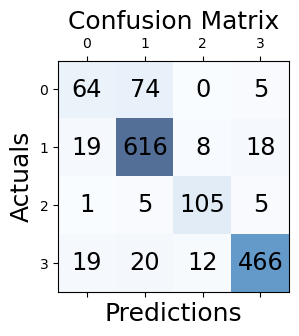

In [57]:
fig,ax = plt.subplots(figsize=(3,3))
ax.matshow(cm_CNN,cmap=plt.cm.Blues,alpha=0.7)
for i in range(cm_CNN.shape[0]):
    for j in range(cm_CNN.shape[1]):
        ax.text(x=j, y=i,s=cm_CNN[i, j],size='xx-large')
plt.ylabel('Actuals',fontsize=18)
plt.style.use("fivethirtyeight")
plt.title('Confusion Matrix',fontsize=18)
plt.xlabel('Predictions',fontsize=18)
plt.show()


# Accuracy for the Validation Data

In [58]:
print(f'Accuracy for validation data: {acc_CNN*100}% ')

Accuracy for validation data: 87.05636743215031% 


# Loss vs Epoch on Train and Validation

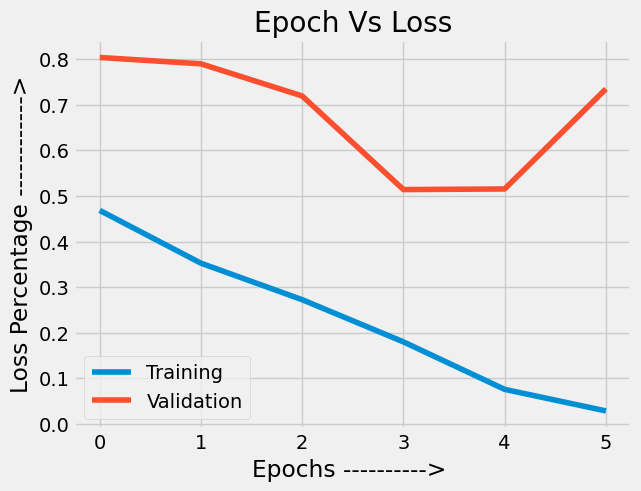

In [59]:
Loss_train_CNN=[t.item() for t in Loss_train_CNN]
Loss_test_CNN=[t.item() for t in Loss_test_CNN]
plt.style.use('fivethirtyeight')
plt.plot(Loss_train_CNN, label='Training')
plt.plot(Loss_test_CNN, label='Validation')
plt.title('Epoch Vs Loss')
plt.xlabel("Epochs ----------> ")
plt.ylabel("Loss Percentage ------------>")
plt.legend();

# Accuracy VS Epoch on Train and Validation

In [60]:
True_train_CNN=[t.item() for t in True_train_CNN]
True_test_CNN=[t.item() for t in True_test_CNN]

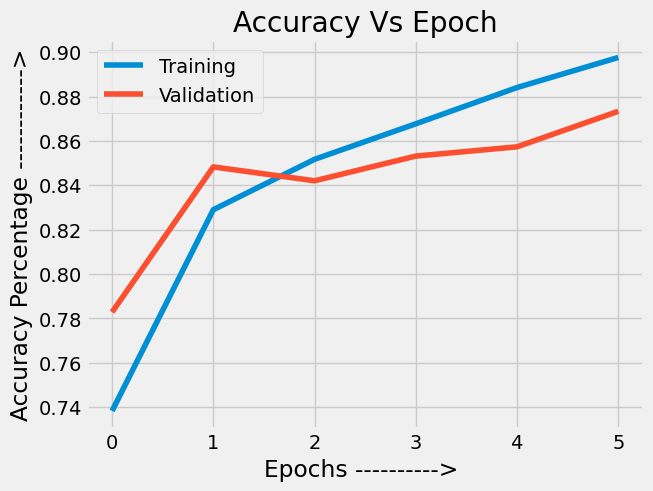

In [61]:
plt.plot([i/Training_image_size for i in True_train_CNN], label='Training')
plt.plot([i/Validation_image_size for i in True_test_CNN], label='Validation')
plt.style.use('fivethirtyeight')
plt.title('Accuracy Vs Epoch')
plt.xlabel("Epochs ----------> ")
plt.ylabel("Accuracy Percentage ------------>")
plt.legend();

# Predicting the Test data

# Using the Loader Function Defined Earlier to transform the data

In [62]:
test_dataset=kan_CustomDataset(csv_file=csv_file_CNN,transform=test_transform_predataloader,root_dir=data_dir_test)
test_loader=DataLoader(test_dataset,shuffle=False,batch_size=16)

# Creting a dataframe

In [63]:
test_csv_CNN=pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')

# Adding GPU for faster Execution

In [64]:
model_CNN=model_CNN.to(device)
model_CNN.eval()

CNN_Base_Model(
  (First): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (Lay1): Linear(in_features=14406, out_features=5000, bias=True)
  (Lay2): Linear(in_features=5000, out_features=2000, bias=True)
  (Lay7): Linear(in_features=2000, out_features=4, bias=True)
)

# Defining labels and adding a DF

In [65]:
df=pd.DataFrame(columns=['Filename','Label'])

# Predicting for each image and storing it in the dataframe

In [66]:
for kan_Image_Name in test_csv_CNN['Filename']:
    one_image=Image.open(os.path.join('/kaggle/input/deep-learning-for-msc-2022-23/test',kan_Image_Name))
    one_image=one_image.convert('RGB')
    one_image=train_transform_predataloader(one_image)
    one_image=one_image.unsqueeze(0)
    one_image=one_image.to(device)
    output1=model_CNN(one_image)
    _,Predicted_label=torch.max(output1.data, 1)
    df=df.append({'Filename': Image_Name,'Label': Predicted_label.item()},ignore_index=True)

# Adding the data in a CSV file, In the prescribed format

In [67]:
df.to_csv('CNN.csv',index=False)

# Captum Model

In [68]:
model_CNN.eval()

CNN_Base_Model(
  (First): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (Lay1): Linear(in_features=14406, out_features=5000, bias=True)
  (Lay2): Linear(in_features=5000, out_features=2000, bias=True)
  (Lay7): Linear(in_features=2000, out_features=4, bias=True)
)

# Storing all 4 classes image in a array by transforming it

In [69]:
input_tensor_arr=[]

input_image0=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/10.png")
input_tensor0=train_transform_predataloader(input_image0) 
input_tensor0=input_tensor0.unsqueeze(0)
input_tensor0=input_tensor0.cuda()
input_tensor_arr.append(input_tensor0)

input_image1=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/1000.png")
input_tensor1=train_transform_predataloader(input_image1) 
input_tensor1=input_tensor1.unsqueeze(0)
input_tensor1=input_tensor1.cuda()
input_tensor_arr.append(input_tensor1)

input_image2=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/4501.png")
input_tensor2=train_transform_predataloader(input_image2) 
input_tensor2=input_tensor2.unsqueeze(0)
input_tensor2=input_tensor2.cuda()
input_tensor_arr.append(input_tensor2)

input_image3=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/7000.png")
input_tensor3=train_transform_predataloader(input_image2) 
input_tensor3=input_tensor3.unsqueeze(0)
input_tensor3=input_tensor3.cuda()
input_tensor_arr.append(input_tensor3)

In [70]:
cmap1=LinearSegmentedColormap.from_list('custom blue',[(0,'#ffffff'),(0.24, '#000000'),(1, '#000000')],N=99)

# Plotting Attribution and Occlusion positive and Negative graph

For class:  0
Noise Tunnel for Class:  0


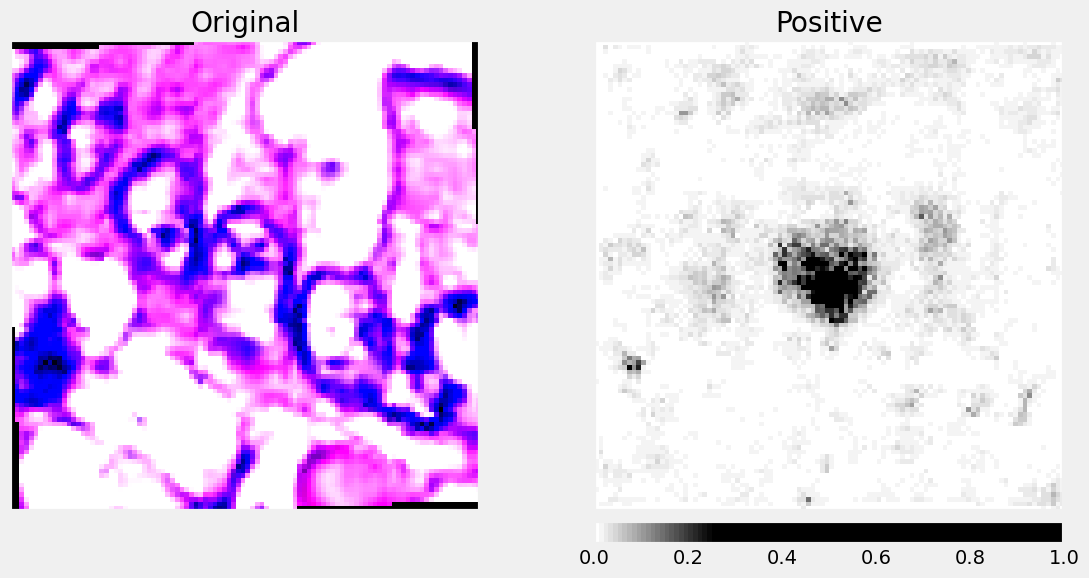

Occlusion for class: 0


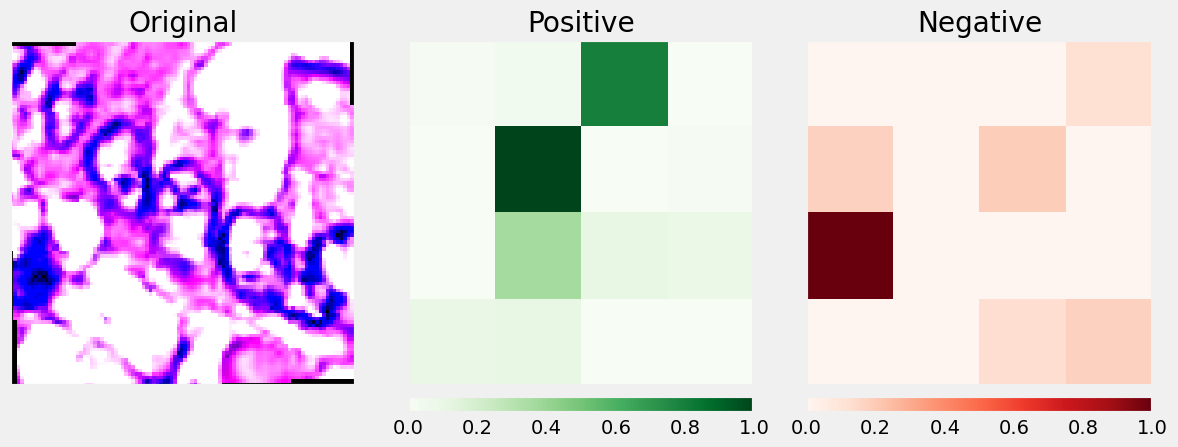

For class:  1
Noise Tunnel for Class:  1


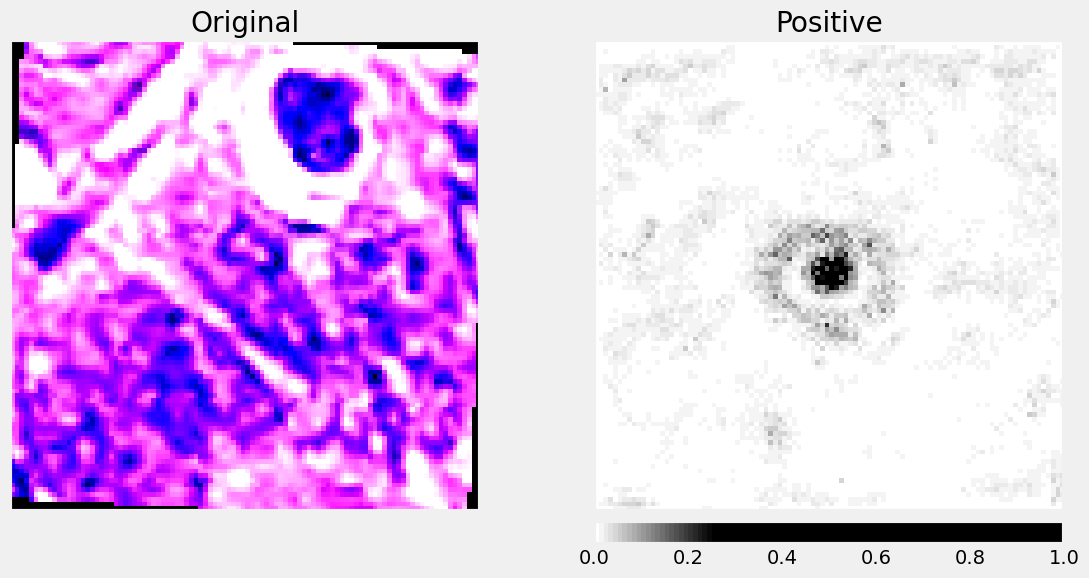

Occlusion for class: 1


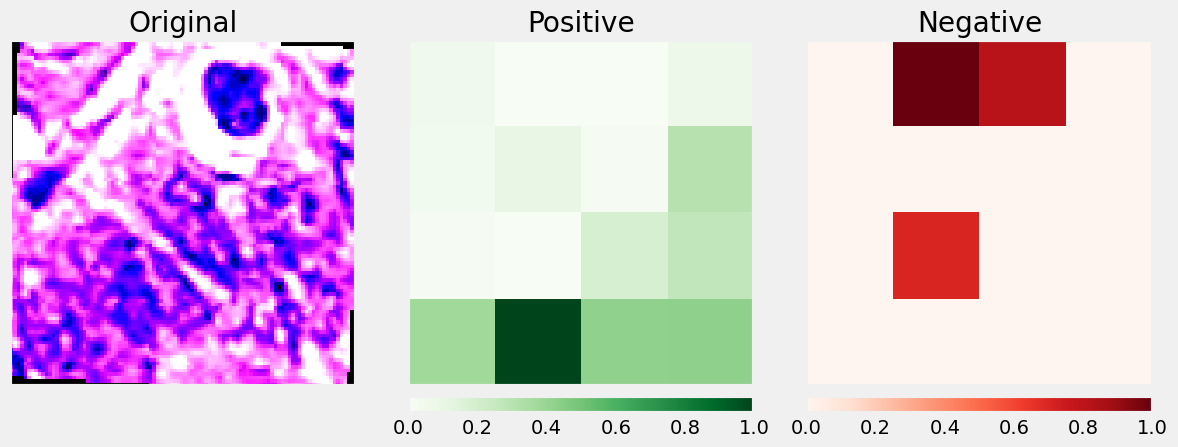

For class:  2
Noise Tunnel for Class:  2


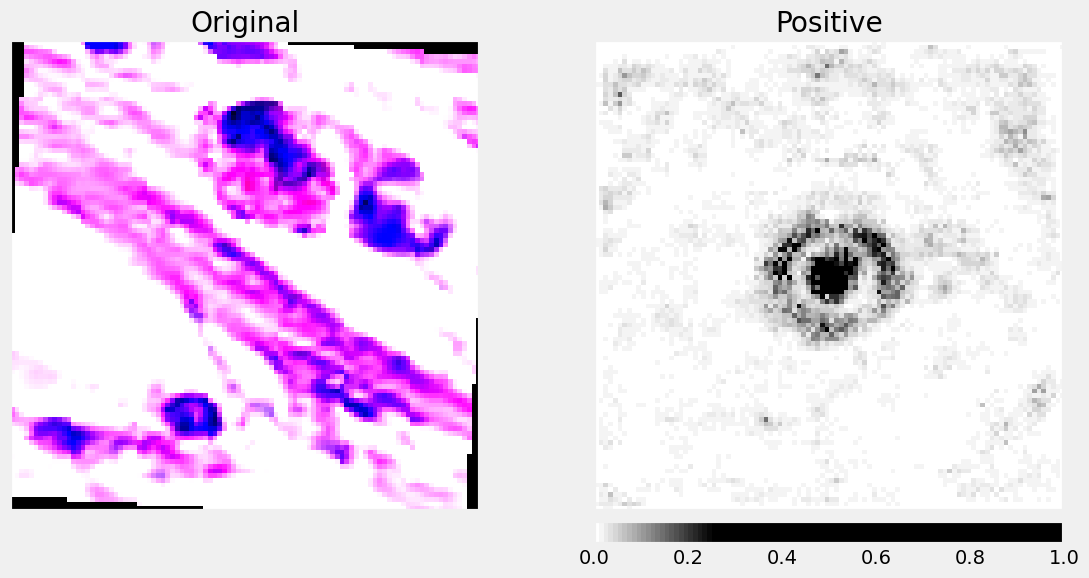

Occlusion for class: 2


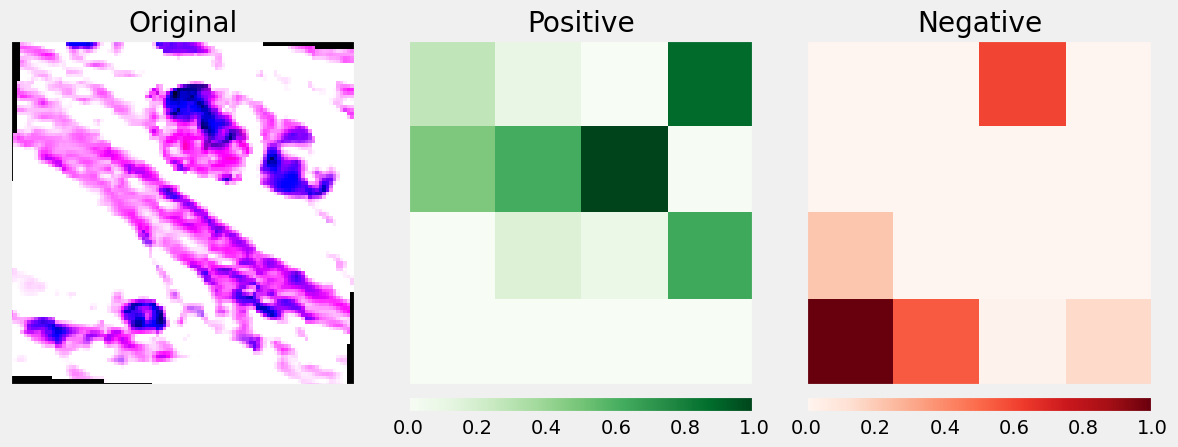

For class:  3
Noise Tunnel for Class:  3


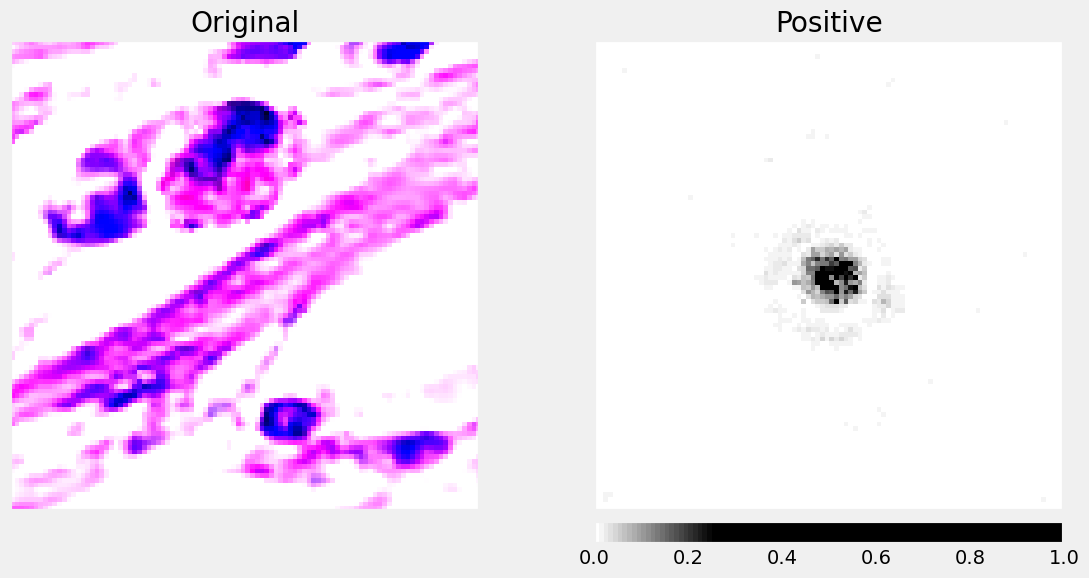

Occlusion for class: 3


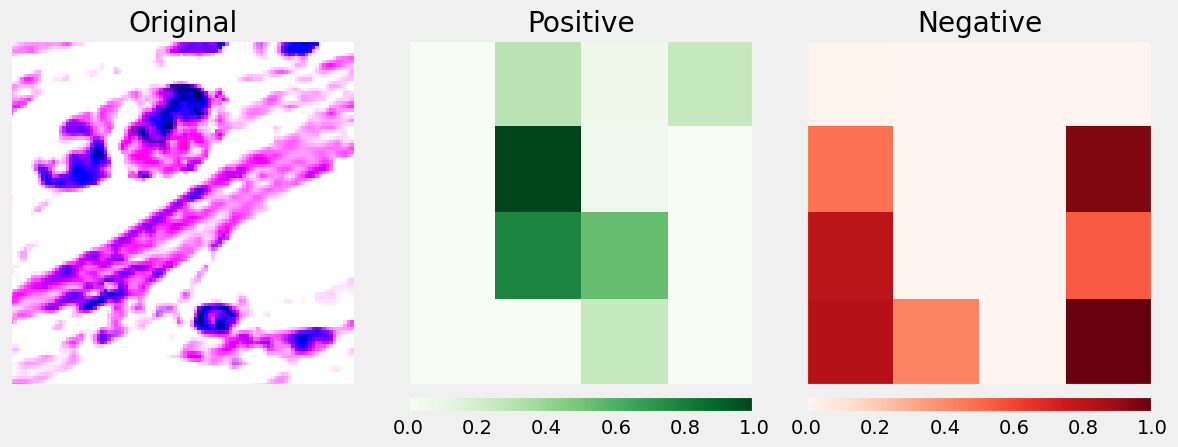

In [71]:
for i in range(4):
    ig=IntegratedGradients(model_CNN)
    attr,delta=ig.attribute(input_tensor_arr[i],target=i,return_convergence_delta=True)
    print(f"For class:  {i}")
    print(f"Noise Tunnel for Class:  {i}")
    nt=NoiseTunnel(ig)
    attributions_ig_nt=nt.attribute(input_tensor_arr[i],nt_samples=10,nt_type='smoothgrad_sq',target=i)
    _=visualization.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),np.transpose(input_tensor_arr[i].squeeze().cpu().detach().numpy(),(1,2,0)),["original_image", "heat_map"],["all", "positive"],cmap=cmap1,fig_size=(12,6), titles=["Original","Positive"], show_colorbar=True)
    print(f"Occlusion for class: {i}")
    oc=Occlusion(model_CNN)
    aoc=oc.attribute(input_tensor_arr[i],strides = (3,25,25),target=i,sliding_window_shapes=(3,25,25),baselines=0)
    _=visualization.visualize_image_attr_multiple(np.transpose(aoc.squeeze().cpu().detach().numpy(), (1,2,0)),np.transpose(input_tensor_arr[i].squeeze().cpu().detach().numpy(),(1,2,0)),["original_image", "heat_map","heat_map"],["all", "positive", "negative"],fig_size=(12,6),titles=["Original","Positive","Negative"],show_colorbar=True)
    

# Discussion on Model 1:

# Model 2( Using Resnet)

### Settng the Epoch count to 15 for the Hyper tunning

In [105]:
Epochs_resnet_ht=15

# Model 2 for Hyper parameter Tuning

### And keeping the feature to 4 as we have 4 classes in the output layer

In [106]:
def kan_Train_ResNet(config):
    model_Resnet=models.resnet50(pretrained=True)
    _4_Fea=model_Resnet.fc.in_features
    model_Resnet.fc=nn.Linear(_4_Fea, 4)
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_Resnet=model_Resnet.to(device)
    Adam_Optimizer_Resnet=torch.optim.Adam(model_Resnet.parameters(),lr=config['lr'])
    L_Func_Resnet=nn.CrossEntropyLoss()
    for i in range(Epochs_resnet_ht):
        for n,(train,label) in enumerate(train_loader):
            n=n+1
            train, label=train.to(device),label.to(device)
            Adam_Optimizer_Resnet.zero_grad()
            label_pred_Resnet=model_Resnet(train) 
            loss_Resnet=L_Func_Resnet(label_pred_Resnet,label)
            loss_Resnet.backward()
            Adam_Optimizer_Resnet.step()
        tune.report(loss_Resnet=loss_Resnet.item())

# ASHA Schedudule

#### To get the minimimum value

In [107]:
ashasceduler_Resnet=ASHAScheduler(metric='loss_Resnet',mode='min')

# CLI Reporter

In [108]:
rep_resnet=CLIReporter(metric_columns=['loss_Resnet','iter'])

# Config for Hyper Parameter Tuning

### Learning Rate 1e-5 to 1e-3

In [109]:
HT_LR_Resnet={"lr": tune.loguniform(1e-5,1e-3)}

# RayTun Parameters and Running to get the best Learning Rate

### With 15 sample and 2 GPU

In [110]:
kan_Resnet_HT=tune.run(kan_Train_ResNet,config=HT_LR_Resnet,scheduler=ashasceduler_Resnet,resources_per_trial={"gpu": 2, "cpu": 2},progress_reporter=rep_resnet,num_samples=15)

== Status ==
Current time: 2023-03-25 19:27:31 (running for 00:00:00.27)
Memory usage on this node: 5.0/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------------+----------+-----------------+-------------+
| Trial name                   | status   | loc             |          lr |
|------------------------------+----------+-----------------+-------------|
| kan_Train_ResNet_161a5_00000 | RUNNING  | 172.19.2.2:5724 | 1.8478e-05  |
| kan_Train_ResNet_161a5_00001 | PENDING  |                 | 5.00785e-05 |
| kan_Train_ResNet_161a5_00002 | PENDING  |                 | 2.83444e-05 |
| kan_Train_ResNet_161a5_00003 | PENDING  |                 | 0.000455073 |


(kan_Train_ResNet pid=5724) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=5724)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=5724) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=5724)   warnings.warn(msg)
(kan_Train_ResNet pid=5724) Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
  0%|          | 0.00/9

== Status ==
Current time: 2023-03-25 19:27:41 (running for 00:00:09.91)
Memory usage on this node: 7.1/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------------+----------+-----------------+-------------+
| Trial name                   | status   | loc             |          lr |
|------------------------------+----------+-----------------+-------------|
| kan_Train_ResNet_161a5_00000 | RUNNING  | 172.19.2.2:5724 | 1.8478e-05  |
| kan_Train_ResNet_161a5_00001 | PENDING  |                 | 5.00785e-05 |
| kan_Train_ResNet_161a5_00002 | PENDING  |                 | 2.83444e-05 |
| kan_Train_ResNet_161a5_00003 | PENDING  |                 | 0.000455073 |


Trial name,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss_Resnet,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
kan_Train_ResNet_161a5_00000,2023-03-25_19-35-35,True,,edfaf92f74bf4aa2ab0c932a19ab27c3,81adab6bcf72,15,0.00433286,172.19.2.2,5724,479.257,31.0024,479.257,1679772935,0,,15,161a5_00000,0.00708961
kan_Train_ResNet_161a5_00001,2023-03-25_19-36-17,True,,2735acad79fa405da9b67b9304a6c848,81adab6bcf72,1,0.272714,172.19.2.2,6683,36.8138,36.8138,36.8138,1679772977,0,,1,161a5_00001,0.00514722
kan_Train_ResNet_161a5_00002,2023-03-25_19-36-58,True,,1ef9bb75aeb843e5bbdc5f2262396234,81adab6bcf72,1,0.110937,172.19.2.2,6787,35.5103,35.5103,35.5103,1679773018,0,,1,161a5_00002,0.00590062
kan_Train_ResNet_161a5_00003,2023-03-25_19-44-58,True,,d36631cd053b46bab8f1f55b0b618bd8,81adab6bcf72,15,0.0849403,172.19.2.2,6882,474.735,30.9074,474.735,1679773498,0,,15,161a5_00003,0.0063715
kan_Train_ResNet_161a5_00004,2023-03-25_19-45-39,True,,d278f517c3b54522b863b36603cb68fe,81adab6bcf72,1,0.130934,172.19.2.2,7655,35.8261,35.8261,35.8261,1679773539,0,,1,161a5_00004,0.00551105
kan_Train_ResNet_161a5_00005,2023-03-25_19-46-21,True,,db669e0b6c7e4fb38e45d0873f9c5b8b,81adab6bcf72,1,0.253051,172.19.2.2,7751,36.6118,36.6118,36.6118,1679773581,0,,1,161a5_00005,0.00497627
kan_Train_ResNet_161a5_00006,2023-03-25_19-47-02,True,,45f8b7bf2daf4af1a4b3cd44a64ad1f1,81adab6bcf72,1,0.799793,172.19.2.2,7854,35.6638,35.6638,35.6638,1679773622,0,,1,161a5_00006,0.00567818
kan_Train_ResNet_161a5_00007,2023-03-25_19-47-44,True,,3af96cbc1363474597d138b17e5b5e38,81adab6bcf72,1,0.526602,172.19.2.2,7945,35.8826,35.8826,35.8826,1679773664,0,,1,161a5_00007,0.00479531
kan_Train_ResNet_161a5_00008,2023-03-25_19-48-26,True,,6e6d792737c7417cbd23f29d51961ba7,81adab6bcf72,1,0.28656,172.19.2.2,8046,37.1025,37.1025,37.1025,1679773706,0,,1,161a5_00008,0.00446796
kan_Train_ResNet_161a5_00009,2023-03-25_19-49-10,True,,163d3ccfcef140c98aa2a04a9d59ce9d,81adab6bcf72,1,1.39463,172.19.2.2,8152,38.4986,38.4986,38.4986,1679773750,0,,1,161a5_00009,0.00492072


== Status ==
Current time: 2023-03-25 19:28:19 (running for 00:00:48.00)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: -0.052310481667518616
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------------+----------+-----------------+-------------+---------------+
| Trial name                   | status   | loc             |          lr |   loss_Resnet |
|------------------------------+----------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00000 | RUNNING  | 172.19.2.2:5724 | 1.8478e-05  |     0.0523105 |
| kan_Train_ResNet_161a5_00001 | PENDING  |                 | 5.00785e-05 |               |
| kan_Train_ResNet_161a5_00002 | PENDING  |            

(kan_Train_ResNet pid=5724) E0325 19:31:55.570944549    5758 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(kan_Train_ResNet pid=5724) E0325 19:31:55.603565907    5758 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:32:00 (running for 00:04:29.33)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.052310481667518616
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------------+----------+-----------------+-------------+---------------+
| Trial name                   | status   | loc             |          lr |   loss_Resnet |
|------------------------------+----------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00000 | RUNNING  | 172.19.2.2:5724 | 1.8478e-05  |    0.00839413 |
| kan_Train_ResNet_161a5_00001 | PENDING  |                 | 5.00785e-05 |               |
| kan_Train_ResNet_161a5_00002 | PENDI

(kan_Train_ResNet pid=5724) E0325 19:32:57.387101866    5758 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:33:02 (running for 00:05:31.15)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.052310481667518616
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (14 PENDING, 1 RUNNING)
+------------------------------+----------+-----------------+-------------+---------------+
| Trial name                   | status   | loc             |          lr |   loss_Resnet |
|------------------------------+----------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00000 | RUNNING  | 172.19.2.2:5724 | 1.8478e-05  |    0.00466583 |
| kan_Train_ResNet_161a5_00001 | PENDING  |                 | 5.00785e-05 |               |
| kan_Train_ResNet_161a5_00002 | PENDI

(kan_Train_ResNet pid=6683) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=6683)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=6683) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=6683)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:35:41 (running for 00:08:10.06)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.052310481667518616
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (13 PENDING, 1 RUNNING, 1 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00001 | RUNNING    | 172.19.2.2:6683 | 5.00785e-05 |               |
| kan_Train_ResNet_161a5_00002 | PENDING    |                 | 2.83444e-05 |               |
| kan_Train_Re

(kan_Train_ResNet pid=6787) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=6787)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=6787) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=6787)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:36:23 (running for 00:08:52.07)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=1
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.10741128399968147
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (12 PENDING, 1 RUNNING, 2 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00002 | RUNNING    | 172.19.2.2:6787 | 2.83444e-05 |               |
| kan_Train_ResNet_161a5_00003 | PENDING    |                 | 0.000455073 |               |
| kan_Train_Res

(kan_Train_ResNet pid=6882) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=6882)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=6882) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=6882)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:37:04 (running for 00:09:33.08)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.08162382617592812
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00003 | RUNNING    | 172.19.2.2:6882 | 0.000455073 |               |
| kan_Train_ResNet_161a5_00004 | PENDING    |                 | 0.000139841 |               |
| kan_Train_Res

(kan_Train_ResNet pid=6882) E0325 19:37:06.608429836    6922 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:37:09 (running for 00:09:38.08)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.08162382617592812
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00003 | RUNNING    | 172.19.2.2:6882 | 0.000455073 |               |
| kan_Train_ResNet_161a5_00004 | PENDING    |                 | 0.000139841 |               |
| kan_Train_Res

(kan_Train_ResNet pid=6882) E0325 19:38:45.892172567    6922 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:38:50 (running for 00:11:19.65)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.031640563160181046 | Iter 1.000: -0.06066466309130192
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00003 | RUNNING    | 172.19.2.2:6882 | 0.000455073 |    0.0915954  |
| kan_Train_ResNet_161a5_00004 | PENDING    |                 | 0.000139841 |               |
| kan_Train_Res

(kan_Train_ResNet pid=6882) E0325 19:40:51.278043185    6922 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:40:56 (running for 00:13:25.04)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.06066466309130192
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00003 | RUNNING    | 172.19.2.2:6882 | 0.000455073 |    0.0638902  |
| kan_Train_ResNet_161a5_00004 | PENDING    |                 | 0.000139841 |               |
| kan_Train_Res

(kan_Train_ResNet pid=6882) E0325 19:44:28.040173451    6922 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(kan_Train_ResNet pid=6882) E0325 19:44:28.073300171    6922 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:44:33 (running for 00:17:01.81)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.06066466309130192
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (11 PENDING, 1 RUNNING, 3 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00003 | RUNNING    | 172.19.2.2:6882 | 0.000455073 |    0.111227   |
| kan_Train_ResNet_161a5_00004 | PENDING    |                 | 0.000139841 |               |
| kan_Train_Res

(kan_Train_ResNet pid=7655) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=7655)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=7655) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=7655)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:45:04 (running for 00:17:33.18)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.06066466309130192
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00004 | RUNNING    | 172.19.2.2:7655 | 0.000139841 |               |
| kan_Train_ResNet_161a5_00005 | PENDING    |                 | 1.76333e-05 |               |
| kan_Train_Res

(kan_Train_ResNet pid=7655) E0325 19:45:06.667899535    7689 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:45:09 (running for 00:17:38.20)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=2
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.06066466309130192
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (10 PENDING, 1 RUNNING, 4 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00004 | RUNNING    | 172.19.2.2:7655 | 0.000139841 |               |
| kan_Train_ResNet_161a5_00005 | PENDING    |                 | 1.76333e-05 |               |
| kan_Train_Res

(kan_Train_ResNet pid=7751) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=7751)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=7751) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=7751)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:45:45 (running for 00:18:14.18)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.06344939023256302
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (9 PENDING, 1 RUNNING, 5 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00005 | RUNNING    | 172.19.2.2:7751 | 1.76333e-05 |               |
| kan_Train_ResNet_161a5_00006 | PENDING    |                 | 0.000908044 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=7854) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=7854)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=7854) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=7854)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:46:27 (running for 00:18:56.20)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.07532133534550667
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00006 | RUNNING    | 172.19.2.2:7854 | 0.000908044 |               |
| kan_Train_ResNet_161a5_00007 | PENDING    |                 | 0.00033463  |               |
| kan_Train_ResN

(kan_Train_ResNet pid=7854) E0325 19:46:29.685875092    7889 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:46:32 (running for 00:19:01.21)
Memory usage on this node: 7.7/15.6 GiB 
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.07532133534550667
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (8 PENDING, 1 RUNNING, 6 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00006 | RUNNING    | 172.19.2.2:7854 | 0.000908044 |               |
| kan_Train_ResNet_161a5_00007 | PENDING    |                 | 0.00033463  |               |
| kan_Train_ResN

(kan_Train_ResNet pid=7945) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=7945)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=7945) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=7945)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:47:13 (running for 00:19:42.21)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.08719328045845032
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (7 PENDING, 1 RUNNING, 7 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00007 | RUNNING    | 172.19.2.2:7945 | 0.00033463  |               |
| kan_Train_ResNet_161a5_00008 | PENDING    |                 | 4.82561e-05 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=8046) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=8046)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=8046) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=8046)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:47:49 (running for 00:20:18.23)
Memory usage on this node: 5.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.09906522557139397
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00008 | RUNNING    | 172.19.2.2:8046 | 4.82561e-05 |               |
| kan_Train_ResNet_161a5_00009 | PENDING    |                 | 0.000826194 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=8046) E0325 19:47:51.975225411    8090 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:47:54 (running for 00:20:23.24)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=6
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.09906522557139397
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (6 PENDING, 1 RUNNING, 8 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00008 | RUNNING    | 172.19.2.2:8046 | 4.82561e-05 |               |
| kan_Train_ResNet_161a5_00009 | PENDING    |                 | 0.000826194 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=8152) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=8152)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=8152) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=8152)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:48:32 (running for 00:21:01.23)
Memory usage on this node: 5.2/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.11093717068433762
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00009 | RUNNING    | 172.19.2.2:8152 | 0.000826194 |               |
| kan_Train_ResNet_161a5_00010 | PENDING    |                 | 0.000105185 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=8152) E0325 19:48:34.949833839    8189 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:48:37 (running for 00:21:06.24)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=7
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.11093717068433762
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (5 PENDING, 1 RUNNING, 9 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00009 | RUNNING    | 172.19.2.2:8152 | 0.000826194 |               |
| kan_Train_ResNet_161a5_00010 | PENDING    |                 | 0.000105185 |               |
| kan_Train_ResN

(kan_Train_ResNet pid=8307) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=8307)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=8307) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=8307)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:49:16 (running for 00:21:45.24)
Memory usage on this node: 5.3/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.11593643762171268
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00010 | RUNNING    | 172.19.2.2:8307 | 0.000105185 |               |
| kan_Train_ResNet_161a5_00011 | PENDING    |                 | 0.00047266  |               |
| kan_Train_Res

(kan_Train_ResNet pid=8307) E0325 19:49:19.044520903    8357 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:49:21 (running for 00:21:50.25)
Memory usage on this node: 7.6/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.11593643762171268
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00010 | RUNNING    | 172.19.2.2:8307 | 0.000105185 |               |
| kan_Train_ResNet_161a5_00011 | PENDING    |                 | 0.00047266  |               |
| kan_Train_Res

(kan_Train_ResNet pid=8307) E0325 19:49:53.156922964    8357 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:49:58 (running for 00:22:26.92)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.030712819192558527 | Iter 1.000: -0.09364895895123482
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00010 | RUNNING    | 172.19.2.2:8307 | 0.000105185 |    0.0763607  |
| kan_Train_ResNet_161a5_00011 | PENDING    |                 | 0.00047266  |               |
| kan_Train_Res

(kan_Train_ResNet pid=8307) E0325 19:51:25.821384422    8357 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:51:30 (running for 00:23:59.59)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.09364895895123482
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (4 PENDING, 1 RUNNING, 10 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00010 | RUNNING    | 172.19.2.2:8307 | 0.000105185 |    0.00757175 |
| kan_Train_ResNet_161a5_00011 | PENDING    |                 | 0.00047266  |               |
| kan_Train_Res

(kan_Train_ResNet pid=9114) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=9114)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=9114) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=9114)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:57:12 (running for 00:29:41.32)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.09364895895123482
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00011 | RUNNING    | 172.19.2.2:9114 | 0.00047266  |               |
| kan_Train_ResNet_161a5_00012 | PENDING    |                 | 1.94383e-05 |               |
| kan_Train_Res

(kan_Train_ResNet pid=9114) E0325 19:57:14.784122195    9154 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:57:17 (running for 00:29:46.33)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.09364895895123482
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (3 PENDING, 1 RUNNING, 11 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00011 | RUNNING    | 172.19.2.2:9114 | 0.00047266  |               |
| kan_Train_ResNet_161a5_00012 | PENDING    |                 | 1.94383e-05 |               |
| kan_Train_Res

(kan_Train_ResNet pid=9207) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=9207)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=9207) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=9207)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:57:53 (running for 00:30:22.32)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.10229306481778622
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (2 PENDING, 1 RUNNING, 12 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00012 | RUNNING    | 172.19.2.2:9207 | 1.94383e-05 |               |
| kan_Train_ResNet_161a5_00013 | PENDING    |                 | 4.67333e-05 |               |
| kan_Train_Res

(kan_Train_ResNet pid=9307) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=9307)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=9307) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=9307)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:58:35 (running for 00:31:04.32)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.11093717068433762
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00013 | RUNNING    | 172.19.2.2:9307 | 4.67333e-05 |               |
| kan_Train_ResNet_161a5_00014 | PENDING    |                 | 0.000648503 |               |
| kan_Train_Re

(kan_Train_ResNet pid=9307) E0325 19:58:37.553072217    9341 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:58:40 (running for 00:31:09.33)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.11093717068433762
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (1 PENDING, 1 RUNNING, 13 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00013 | RUNNING    | 172.19.2.2:9307 | 4.67333e-05 |               |
| kan_Train_ResNet_161a5_00014 | PENDING    |                 | 0.000648503 |               |
| kan_Train_Re

(kan_Train_ResNet pid=9400) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(kan_Train_ResNet pid=9400)   f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
(kan_Train_ResNet pid=9400) /opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
(kan_Train_ResNet pid=9400)   warnings.warn(msg)


== Status ==
Current time: 2023-03-25 19:59:16 (running for 00:31:45.34)
Memory usage on this node: 5.4/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.11593643762171268
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00014 | RUNNING    | 172.19.2.2:9400 | 0.000648503 |               |
| kan_Train_ResNet_161a5_00000 | TERMINATED | 172.19.2.2:5724 | 1.8478e-05  |    0.00433286 |
| kan_Train_ResNet_161a5_

(kan_Train_ResNet pid=9400) E0325 19:59:18.888021968    9440 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers
(kan_Train_ResNet pid=9400) E0325 19:59:18.908246384    9440 fork_posix.cc:76]           Other threads are currently calling into gRPC, skipping fork() handlers


== Status ==
Current time: 2023-03-25 19:59:21 (running for 00:31:50.35)
Memory usage on this node: 7.9/15.6 GiB 
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.11593643762171268
Resources requested: 2.0/2 CPUs, 2.0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (1 RUNNING, 14 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00014 | RUNNING    | 172.19.2.2:9400 | 0.000648503 |               |
| kan_Train_ResNet_161a5_00000 | TERMINATED | 172.19.2.2:5724 | 1.8478e-05  |    0.00433286 |
| kan_Train_ResNet_161a5_

2023-03-25 19:59:52,311	INFO tune.py:763 -- Total run time: 1941.09 seconds (1940.93 seconds for the tuning loop).


== Status ==
Current time: 2023-03-25 19:59:52 (running for 00:32:20.95)
Memory usage on this node: 7.8/15.6 GiB 
Using AsyncHyperBand: num_stopped=12
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: -0.018987661926075816 | Iter 1.000: -0.12093570455908775
Resources requested: 0/2 CPUs, 0/2 GPUs, 0.0/6.35 GiB heap, 0.0/3.17 GiB objects (0.0/1.0 accelerator_type:T4)
Result logdir: /root/ray_results/kan_Train_ResNet_2023-03-25_19-27-31
Number of trials: 15/15 (15 TERMINATED)
+------------------------------+------------+-----------------+-------------+---------------+
| Trial name                   | status     | loc             |          lr |   loss_Resnet |
|------------------------------+------------+-----------------+-------------+---------------|
| kan_Train_ResNet_161a5_00000 | TERMINATED | 172.19.2.2:5724 | 1.8478e-05  |    0.00433286 |
| kan_Train_ResNet_161a5_00001 | TERMINATED | 172.19.2.2:6683 | 5.00785e-05 |    0.272714   |
| kan_Train_ResNet_161a5_00002 | TERMINA

# Printing the best parameter and storing it in a variable

In [117]:
kan_LR_Resnet=0
kan_best_Resnet_HT=kan_Resnet_HT.get_best_config(metric='loss_Resnet',mode='min')
for key, value in kan_best_Resnet_HT.items():
    kan_LR_Resnet=value
print(f"Best Performing LR Score with {Epochs_resnet_ht} Epoch is : {kan_LR_Resnet}")

Best Performing LR Score with 15 Epoch is : 1.847800389567061e-05


# Defining a new model to train it with the best parameter

### Added one more variable to store the LR, as it takes a lot of time t run.so cant run it all the time

In [59]:
kan_LR_Resnet=1.847800389567061e-05
model_Resnet_Final = models.resnet50(pretrained=True)
_4_fea_Final = model_Resnet_Final.fc.in_features
model_Resnet_Final.fc = nn.Linear(_4_fea_Final, 4)

# Defining the epochs

In [60]:
epochs_resnet=8

# Defining two variable for confusion matrix and the accuracy

In [61]:
cm_resnet=[[]]
acc_resnet=0

# Defining few arrays to store the Loss and Accuracy for the traing and the validation data after each epochs

In [62]:
True_train_resnet=[]
True_test_resnet=[]
Loss_train_resnet=[]
Loss_test_resnet=[]

# Checking GPU Availablity

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_Resnet_Final=model_Resnet_Final.to(device)
print(device)

cuda


# Defining the optimizer and the loss function with the best Learning Rate

In [64]:
Adam_Optimizer_Resnet_final=torch.optim.Adam(model_Resnet_Final.parameters(), lr=kan_LR_Resnet)
L_Func_Resnet_final=nn.CrossEntropyLoss()

# Defining a start time

In [65]:
start_time_resnet_final=time.time()

# Defining a Loop to Train the model for defined number of epochs, and also to test the on the validation data

In [66]:
warnings.filterwarnings("ignore")
for i in range(epochs_resnet):# Loop with Epochs
    Correct_train_resnet=0
    Correct_test_resnet=0
    for n,(train, label) in enumerate(train_loader):
        n=n+1
        train, label=train.to(device), label.to(device)
        Adam_Optimizer_Resnet_final.zero_grad()
        label_pred=model_Resnet_Final(train) 
        loss_resnet=L_Func_Resnet_final(label_pred, label)
        Correct_train_resnet +=(torch.max(label_pred.data, 1)[1]==label).sum()
        loss_resnet.backward()
        Adam_Optimizer_Resnet_final.step()
        if n%100==0:
            print(f'epoch: {i:3}  Loss: {loss_resnet.item():5.3f} Accuracy: {Correct_train_resnet.item()*100/(16*n):7.2f} %')
    # for plotting storing the loss and accuracy values
    Loss_train_resnet.append(loss_resnet)
    True_train_resnet.append(Correct_train_resnet)
    # Test
    with torch.no_grad():
        for n,(test_resnet, label_resnet) in enumerate(test_loader):
            n=n+1
            test_resnet, label_resnet=test_resnet.to(device), label_resnet.to(device)
            label_pred_resnet=model_Resnet_Final(test_resnet)
            Correct_test_resnet +=(torch.max(label_pred_resnet.data, 1)[1]==label_resnet).sum()
            
    # Calculate the loss
    loss_resnet=L_Func_Resnet_final(label_pred_resnet, label_resnet)
    Loss_test_resnet.append(loss_resnet)
    True_test_resnet.append(Correct_test_resnet)
    
    # To save Confusion matrix and accuracy score in the last epochs
    if i==epochs_resnet - 1: 
        pred_resnet=[]
        true_resnet=[]
        with torch.no_grad():
            for data_resnet in test_loader:
                X_test_resnet, y_test_resnet=data_resnet
                X_test_resnet, y_test_resnet=X_test_resnet.cuda(), y_test_resnet.cuda()
                y_val_resnet=model_Resnet_Final(X_test_resnet)
                predicted_resnet=torch.max(y_val_resnet.data, 1)[1]
                pred_resnet.extend(predicted_resnet.cpu().numpy())
                true_resnet.extend(y_test_resnet.cpu().numpy())
        cm_resnet=confusion_matrix(true_resnet, pred_resnet)
        acc_resnet=accuracy_score(true_resnet, pred_resnet)
        
print(f'\nDuration: {time.time() - start_time_resnet_final:.0f} seconds')

epoch:  0  Loss: 0.812   Accuracy:   72.25 %
epoch:  0  Loss: 0.238   Accuracy:   77.75 %
epoch:  0  Loss: 0.585   Accuracy:   81.27 %
epoch:  1  Loss: 0.341   Accuracy:   93.19 %
epoch:  1  Loss: 0.694   Accuracy:   92.91 %
epoch:  1  Loss: 0.278   Accuracy:   93.27 %
epoch:  2  Loss: 0.049   Accuracy:   95.38 %
epoch:  2  Loss: 0.246   Accuracy:   95.09 %
epoch:  2  Loss: 0.316   Accuracy:   95.29 %
epoch:  3  Loss: 0.057   Accuracy:   96.62 %
epoch:  3  Loss: 0.027   Accuracy:   96.56 %
epoch:  3  Loss: 0.024   Accuracy:   96.62 %
epoch:  4  Loss: 0.030   Accuracy:   97.88 %
epoch:  4  Loss: 0.018   Accuracy:   97.91 %
epoch:  4  Loss: 0.018   Accuracy:   97.71 %
epoch:  5  Loss: 0.023   Accuracy:   98.31 %
epoch:  5  Loss: 0.010   Accuracy:   98.50 %
epoch:  5  Loss: 0.016   Accuracy:   98.50 %
epoch:  6  Loss: 0.086   Accuracy:   99.12 %
epoch:  6  Loss: 0.069   Accuracy:   98.75 %
epoch:  6  Loss: 0.057   Accuracy:   98.83 %
epoch:  7  Loss: 0.151   Accuracy:   98.88 %
epoch:  7 

# Confusion Matrix for the Validation Data

# Using MatplotLib

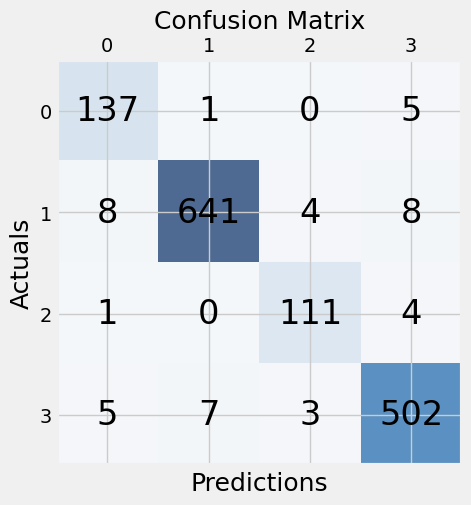

In [68]:
fig,ax = plt.subplots(figsize=(5,5))
ax.matshow(cm_resnet, cmap=plt.cm.Blues, alpha=0.7)
for i in range(cm_resnet.shape[0]):
    for j in range(cm_resnet.shape[1]):
        ax.text(x=j, y=i,s=cm_resnet[i, j],size='xx-large')
plt.style.use("fivethirtyeight")
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predictions', fontsize=18)
plt.show()

# Accuracy for the Validation Data

In [69]:
print(f'Accuracy for Validation data: {acc_resnet*100}% ')

Accuracy for Validation data: 96.79888656924147% 


# Loss vs Epoch on Train and Test

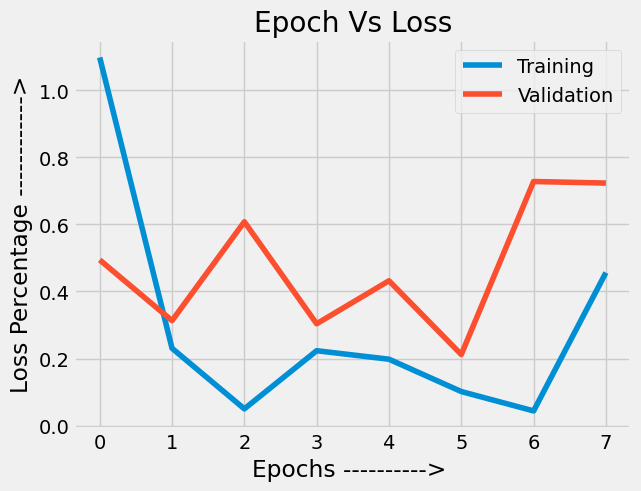

In [70]:
Loss_train_resnet=[t.item() for t in Loss_train_resnet]
Loss_test_resnet=[t.item() for t in Loss_test_resnet]
plt.style.use('fivethirtyeight')
plt.plot(Loss_train_resnet, label='Training')
plt.plot(Loss_test_resnet, label='Validation')
plt.title('Epoch Vs Loss')
plt.xlabel("Epochs ----------> ")
plt.ylabel("Loss Percentage ------------>")
plt.legend();

# Converting Tensor list to List

In [71]:
True_train_resnet=[t.item() for t in True_train_resnet]
True_test_resnet=[t.item() for t in True_test_resnet]

# Accuracy VS Epoch on Train and Test

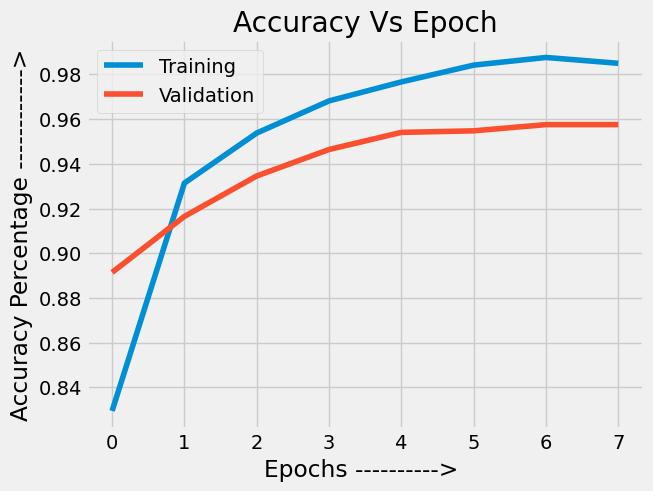

In [72]:
plt.style.use('fivethirtyeight')
plt.plot([i/len(train_loader.dataset) for i in True_train_resnet], label='Training')
plt.plot([i/len(test_loader.dataset) for i in True_test_resnet], label='Validation')
plt.title('Accuracy Vs Epoch')
plt.xlabel("Epochs ----------> ")
plt.ylabel("Accuracy Percentage ------------>")
plt.legend();

# Predicting the Test data

### Loading all file name from the folder

In [73]:
csv_file_Resnet='/kaggle/input/deep-learning-for-msc-2022-23/example.csv'
data_dir_test='/kaggle/input/deep-learning-for-msc-2022-23/test'

# Using the Custom Dataset and the DataLoader to predict the output for the test set

In [74]:
test_dataset_resnet=kan_CustomDataset(csv_file=csv_file_Resnet,transform=train_transform_predataloader,root_dir=data_dir_test)
test_loader_resnet=DataLoader(test_dataset_resnet,shuffle=False,batch_size=16)


In [75]:
test_csv_resnet=pd.read_csv('/kaggle/input/deep-learning-for-msc-2022-23/example.csv')

# Adding GPU 

In [76]:
model_Resnet_Final=model_Resnet_Final.to(device)
model_Resnet_Final.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Creating a dataframe to store the results

In [77]:
df_resnet=pd.DataFrame(columns=['Filename','Label'])

# Predicting the output for each image and storing it in the dataframe with the maximum probablity 

In [78]:
for Image_Name_Resnet in test_csv_resnet['Filename']:
    one_image_resnet=Image.open(os.path.join('/kaggle/input/deep-learning-for-msc-2022-23/test',Image_Name_Resnet))
    one_image_resnet=one_image_resnet.convert('RGB')
    one_image_resnet=train_transform_predataloader(one_image_resnet)
    one_image_resnet=one_image_resnet.unsqueeze(0)
    one_image_resnet=one_image_resnet.to(device)
    output_resnet=model_Resnet_Final(one_image_resnet)
    _,Predicted_label_resnet=torch.max(output_resnet.data, 1)
    df_resnet=df_resnet.append({'Filename': Image_Name_Resnet,'Label': Predicted_label_resnet.item()},ignore_index=True)

# Storing the dataframe result into a CSV file to submit it on Kaggle

In [79]:
df_resnet.to_csv('last_final.csv',index=False)

# Captum Model

In [80]:
model_Resnet_Final.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Check Positive and the the original image for each class using the madel 2

In [81]:
input_tensor_arr=[]

input_image0=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/10.png")
input_tensor0=train_transform_predataloader(input_image0) 
input_tensor0=input_tensor0.unsqueeze(0)
input_tensor0=input_tensor0.cuda()
input_tensor_arr.append(input_tensor0)

input_image1=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/1001.png")
input_tensor1=train_transform_predataloader(input_image1) 
input_tensor1=input_tensor1.unsqueeze(0)
input_tensor1=input_tensor1.cuda()
input_tensor_arr.append(input_tensor1)

input_image2=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/4501.png")
input_tensor2=train_transform_predataloader(input_image2) 
input_tensor2=input_tensor2.unsqueeze(0)
input_tensor2=input_tensor2.cuda()
input_tensor_arr.append(input_tensor2)

input_image3=Image.open("/kaggle/input/deep-learning-for-msc-2022-23/train/7000.png")
input_tensor3=train_transform_predataloader(input_image2) 
input_tensor3=input_tensor3.unsqueeze(0)
input_tensor3=input_tensor3.cuda()
input_tensor_arr.append(input_tensor3)

## Orignal and the positive image

For class 0
Noise Tunnel for Class 0


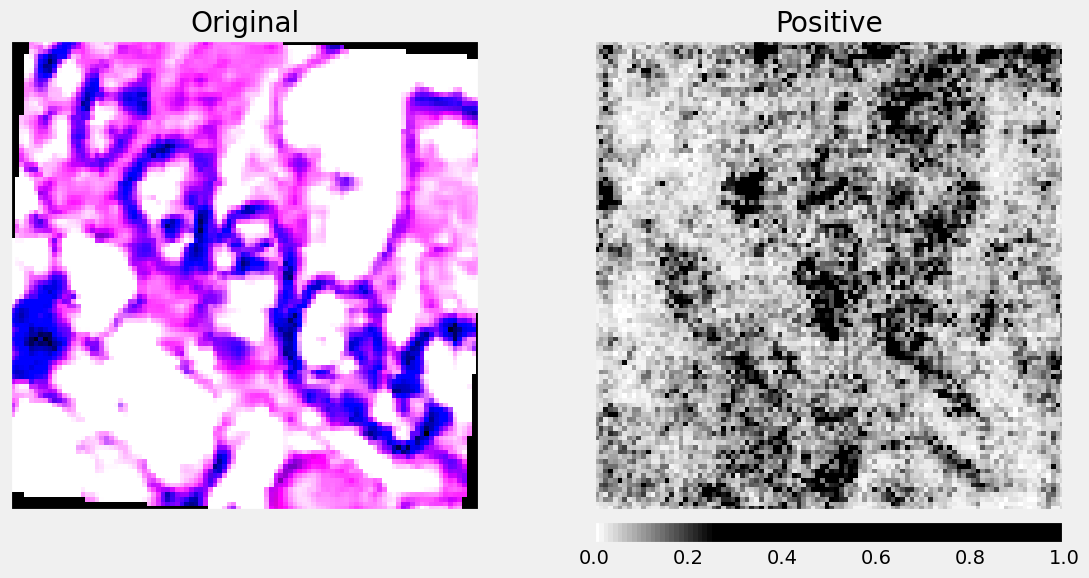

Occlusion for class 0


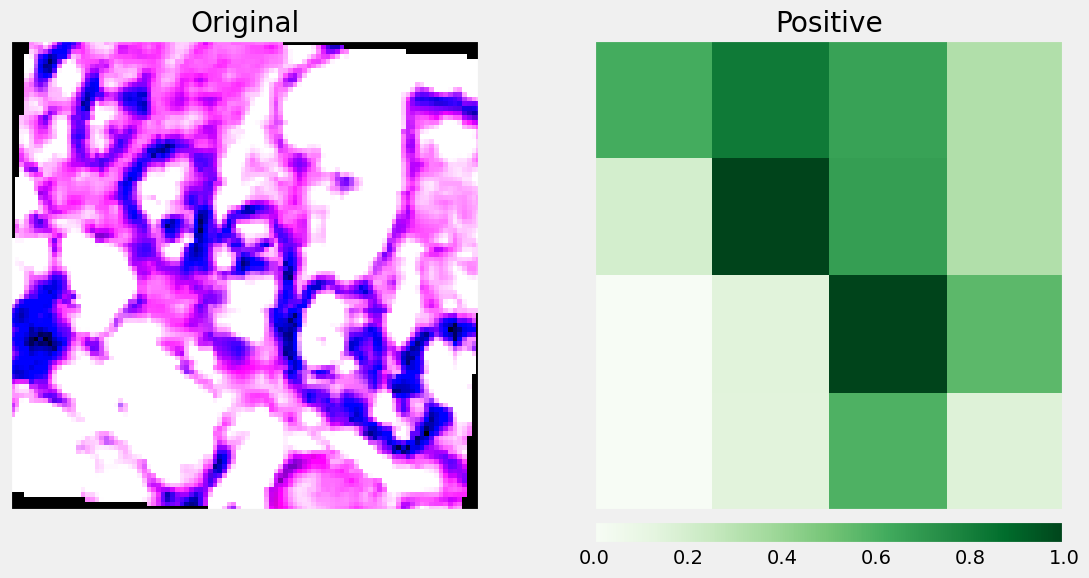

For class 1
Noise Tunnel for Class 1


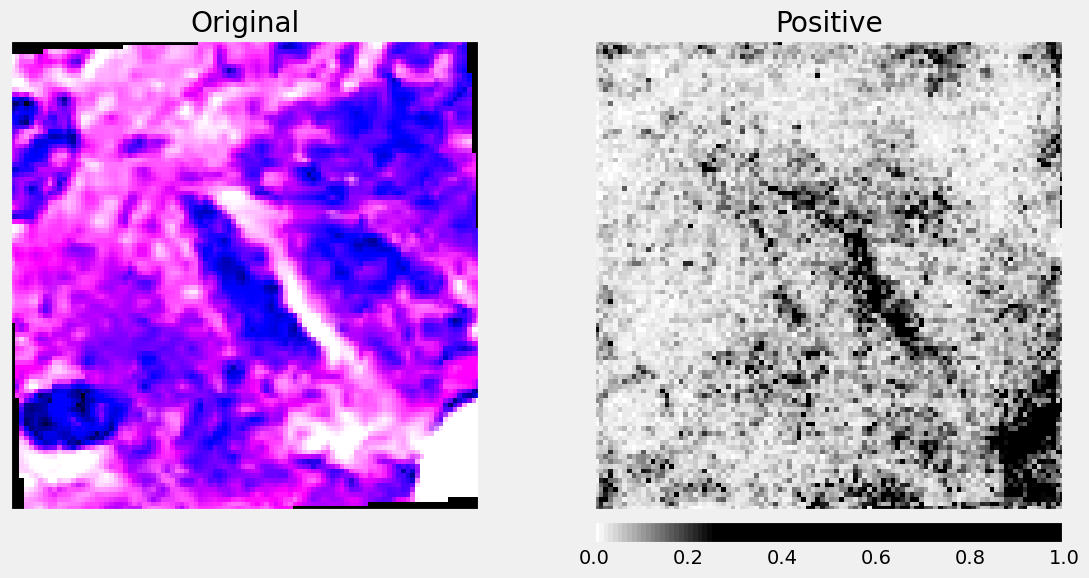

Occlusion for class 1


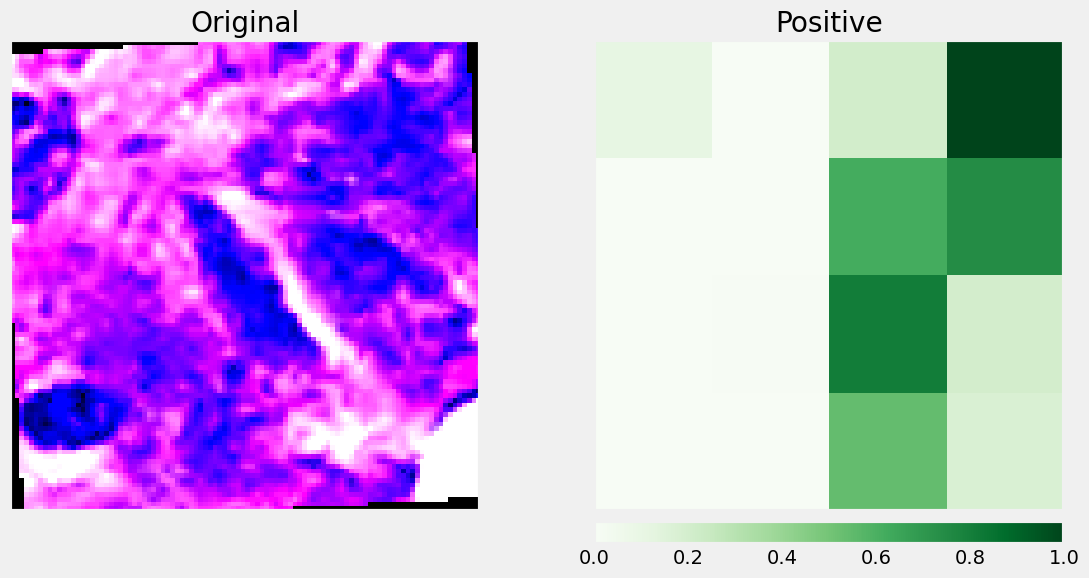

For class 2
Noise Tunnel for Class 2


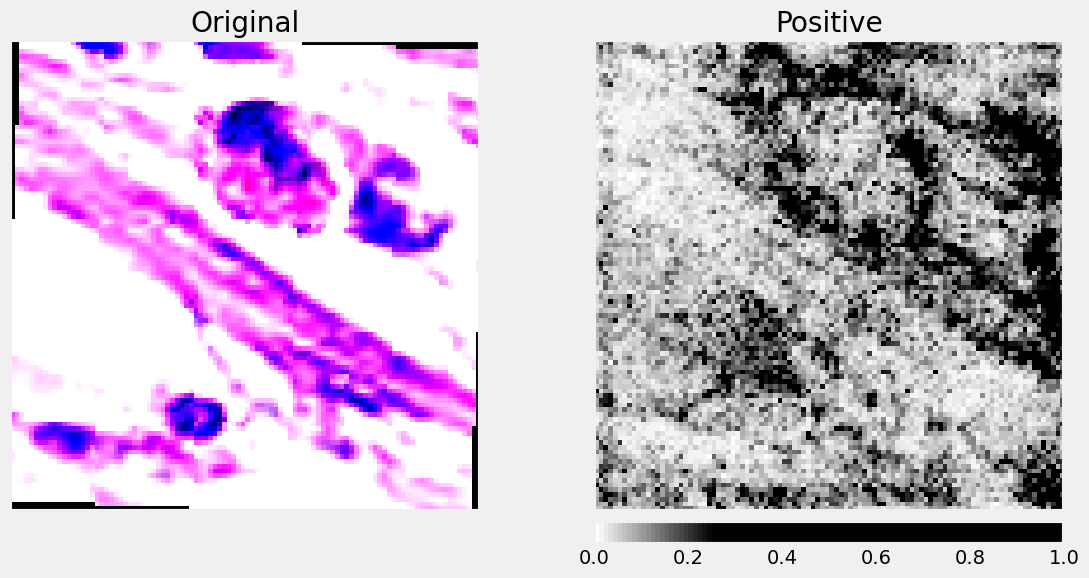

Occlusion for class 2


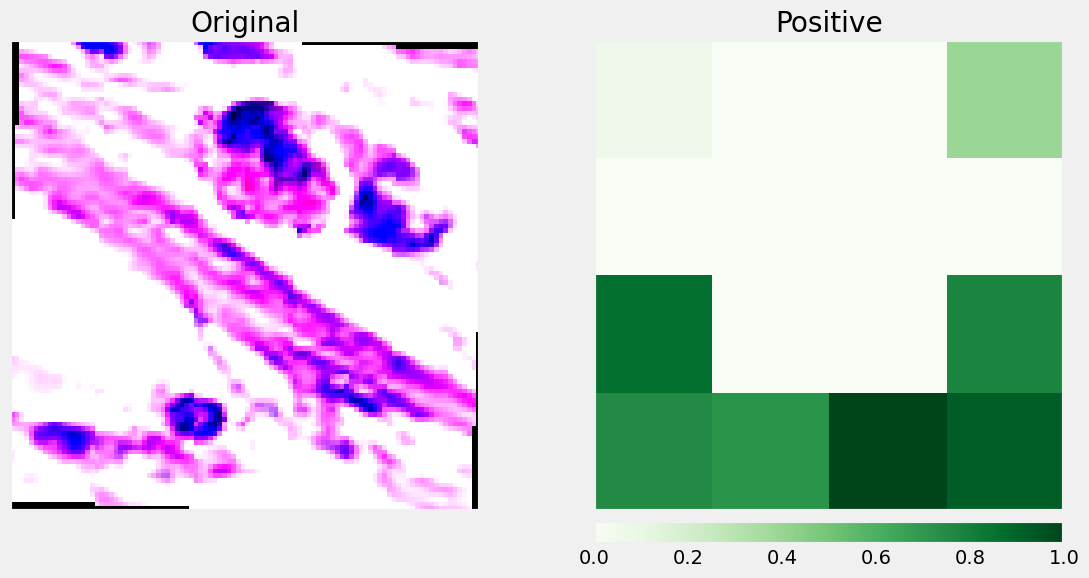

For class 3
Noise Tunnel for Class 3


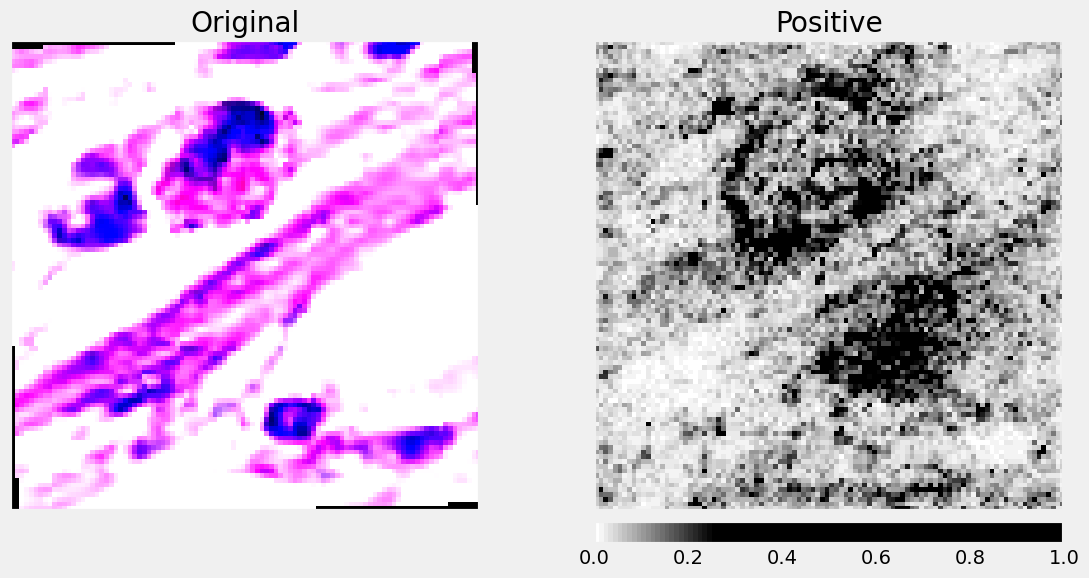

Occlusion for class 3


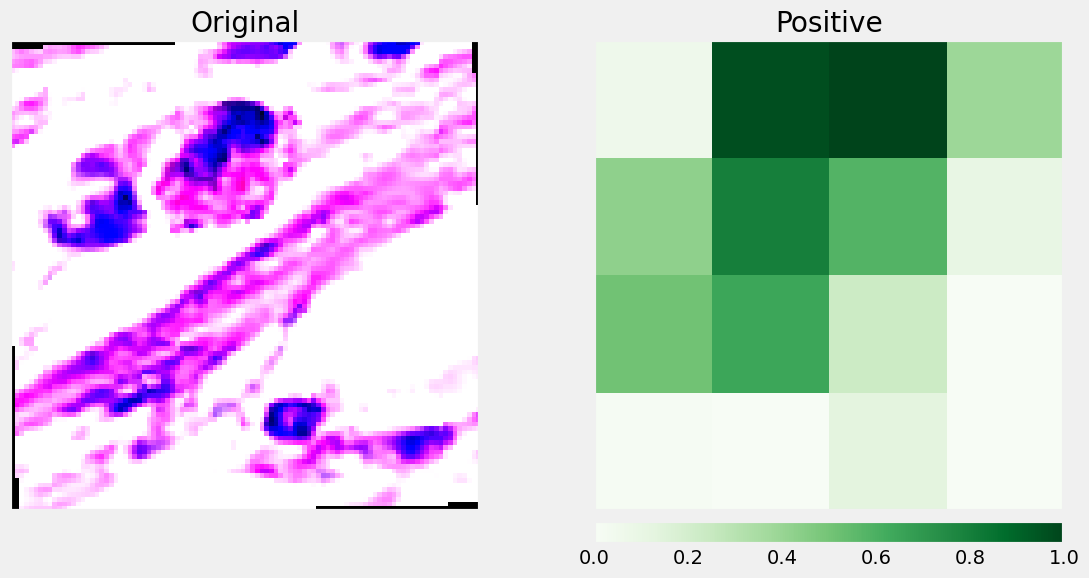

In [82]:
for i in range(4):
    #Used Captum
    ig2=IntegratedGradients(model_Resnet_Final)
    attr,delta=ig2.attribute(input_tensor_arr[i],target=i,return_convergence_delta=True)
    print(f"For class {i}")
    print(f"Noise Tunnel for Class {i}")
    nt=NoiseTunnel(ig2)
    attributions_ig_nt = nt.attribute(input_tensor_arr[i],nt_samples=10,nt_type='smoothgrad_sq',target=i)
    _=visualization.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(input_tensor_arr[i].squeeze().cpu().detach().numpy(),(1,2,0)),["original_image","heat_map"],["all","positive"],cmap=cmap1,fig_size=(12,6), titles=["Original","Positive"], show_colorbar=True)
    print(f"Occlusion for class {i}")
    oc=Occlusion(model_Resnet_Final)
    aoc=oc.attribute(input_tensor_arr[i],strides=(3,25,25),target=i,sliding_window_shapes=(3,25,25),baselines=0)
    _=visualization.visualize_image_attr_multiple(np.transpose(aoc.squeeze().cpu().detach().numpy(),(1,2,0)),np.transpose(input_tensor_arr[i].squeeze().cpu().detach().numpy(),(1,2,0)),["original_image","heat_map"],["all","positive"],fig_size=(12,6),titles=["Original","Positive"],show_colorbar=True)

# Discussion on Model 2